Input images for this are from the diffIm_demo DECAM data that Yusra gave me. 
First, I ran `imageDifference.py` with `doDecorrelation = False`. Then copied the diffim to the current directory:
```
cp decamDirTest/deepDiff/v289820/diffexp-11.fits .
```
Then I ran it with `doDecorrelation = True`, and then copied the diffim:
```
cp decamDirTest/deepDiff/v289820/diffexp-11.fits ./diffexp-11-ALZC.fits
```

I will note also, that without the correction, at 5.5 sigma, 58,98 positive,negative sources were detected.

With the correction it is only 38,15 (also at 5.5 sigma, though).

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

#  LSST imports:
import lsst.afw.image as afwImage
from lsst.afw.table import (SourceTable, SourceCatalog)
from lsst.meas.base import SingleFrameMeasurementConfig
from lsst.meas.algorithms import (SourceDetectionConfig, SourceDetectionTask)

import diffimTests as dit
import lsst.ip.diffim.imageDecorrelation as id

reload(dit)
reload(id);

In [2]:
im1 = afwImage.ExposureF('diffexp-11.fits')
im2 = afwImage.ExposureF('diffexp-11-ALZC.fits') 

In [3]:
sig1 = im1.getMaskedImage().getVariance()
sig2 = im2.getMaskedImage().getVariance()
print id.computeClippedImageStats(sig1)
print id.computeClippedImageStats(sig2)

sig1squared, _, _ = id.computeClippedImageStats(sig1)
sig2squared, _, _ = id.computeClippedImageStats(sig2)
print np.sqrt(sig1squared), np.sqrt(sig2squared)

sig1 = im1.getMaskedImage().getImage()
sig2 = im2.getMaskedImage().getImage()
print id.computeClippedImageStats(sig1)
print id.computeClippedImageStats(sig2)

_, _, sig1squared = id.computeClippedImageStats(sig1)
_, _, sig2squared = id.computeClippedImageStats(sig2)
print np.sqrt(sig1squared), np.sqrt(sig2squared)

(66.89930937449972, 2.534175418012832, 6.422045049260512)
(129.61449489879246, 4.896781179532246, 23.978465920221215)
8.17919980038 11.3848361823
(-0.4826783537777688, 8.635277073950938, 74.56801014390267)
(-0.47060248086882106, 11.943901614331576, 142.65678577283242)
8.63527707395 11.9439016143


UNCORRECTED: (-0.4826783537777688, 8.635277073950938, 74.56801014390267)
CORRECTED:   (-0.47060248086882106, 11.943901614331576, 142.65678577283242)
EXPECTED:    14.7385479582
8090901 7945049


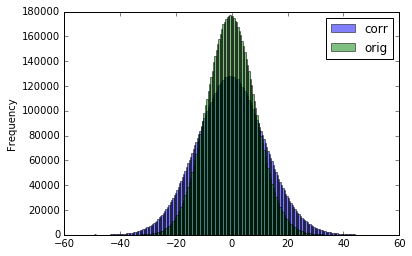

In [4]:
import scipy.stats

im1a = im1.getMaskedImage().getImage()
im2a = im2.getMaskedImage().getImage()
print 'UNCORRECTED:', id.computeClippedImageStats(im1a)
print 'CORRECTED:  ', id.computeClippedImageStats(im2a)
print 'EXPECTED:   ', np.sqrt(sig1squared + sig2squared)

im1a = im1a.getArray()[~(np.isnan(im1a.getArray())|np.isinf(im1a.getArray()))]
im2a = im2a.getArray()[~(np.isnan(im2a.getArray())|np.isinf(im2a.getArray()))]
im1a = im1a[im1a != 0.]
im2a = im2a[im2a != 0.]
im1a, _, _ = scipy.stats.sigmaclip(im1a)
im2a, _, _ = scipy.stats.sigmaclip(im2a)
print len(im1a), len(im2a)
im1a = im1a[:len(im2a)]

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a})
df.plot.hist(alpha=0.5, bins=200)

0.349174543978
0.0777336545077


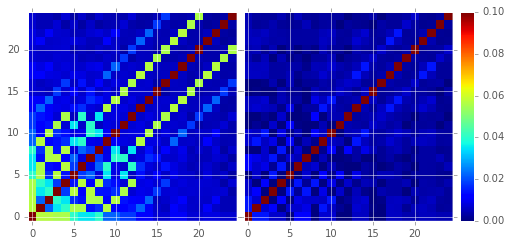

In [5]:
im1a = im1.getMaskedImage().getImage().getArray()
im1a[np.isnan(im1a)|np.isinf(im1a)] = 0.
_, low, upp = scipy.stats.sigmaclip(im1a)
im1a[(im1a < low)|(im1a > upp)] = 0.
cov1 = dit.computePixelCovariance(im1a)

im2a = im2.getMaskedImage().getImage().getArray()
im2a[np.isnan(im2a)|np.isinf(im2a)] = 0.
_, low, upp = scipy.stats.sigmaclip(im2a)
im2a[(im2a < low)|(im2a > upp)] = 0.
cov2 = dit.computePixelCovariance(im2a)

dit.plotImageGrid((cov1, cov2), imScale=4., clim=(0, 0.1), cmap=None)

True
1.99417145453 2.16249579115
1.00014561851 1.0
(14, 14) (14, 15)


DescribeResult(nobs=841, minmax=(-0.0025306128672166091, 0.0055596159562948423), mean=1.7314923479101396e-07, variance=2.6978958505571392e-07, skewness=4.973540431637139, kurtosis=47.97029045223726)

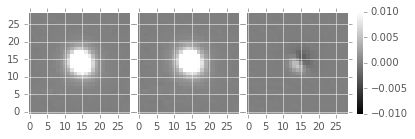

In [6]:
print im2.hasPsf()
im1_psf = im1.getPsf().computeImage().getArray()
im2_psf = im2.getPsf().computeImage().getArray()
print im1.getPsf().computeShape().getDeterminantRadius(), im2.getPsf().computeShape().getDeterminantRadius()
print im1_psf.sum(), im2_psf.sum()
print np.unravel_index(im1_psf.argmax(), im1_psf.shape), np.unravel_index(im2_psf.argmax(), im2_psf.shape)
dit.plotImageGrid((im1.getPsf().computeImage().getArray(), im2_psf, 
                   im1.getPsf().computeImage().getArray() - im2_psf), imScale=2., clim=(-0.01,0.01))
scipy.stats.describe(im1.getPsf().computeImage().getArray() - im2_psf, None)

Here we note that the variance planes are not updated correctly... or 

UNCORRECTED: (66.89930937449972, 2.534175418012832, 6.422045049260512)
CORRECTED:   (129.61449489879246, 4.896781179532246, 23.978465920221215)
EXPECTED:    14.7385479582
7520808 7236456
DescribeResult(nobs=7236456, minmax=(56.53104, 77.36792), mean=66.936821, variance=6.8034019, skewness=0.24816212058067322, kurtosis=0.1926599804243545)
DescribeResult(nobs=7236456, minmax=(109.55919, 149.89359), mean=129.69576, variance=25.498131, skewness=0.26433467864990234, kurtosis=0.22697571182754528)


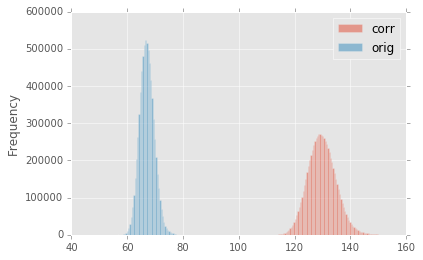

In [7]:
im1a = im1.getMaskedImage().getVariance()
im2a = im2.getMaskedImage().getVariance()

print 'UNCORRECTED:', id.computeClippedImageStats(im1a)
print 'CORRECTED:  ', id.computeClippedImageStats(im2a)
print 'EXPECTED:   ', np.sqrt(sig1squared + sig2squared)

im1a = im1a.getArray()[~(np.isnan(im1a.getArray())|np.isinf(im1a.getArray()))]
im2a = im2a.getArray()[~(np.isnan(im2a.getArray())|np.isinf(im2a.getArray()))]
im1a = im1a[im1a != 0.]
im2a = im2a[im2a != 0.]
im1a, _, _ = scipy.stats.sigmaclip(im1a)
im2a, _, _ = scipy.stats.sigmaclip(im2a)
print len(im1a), len(im2a)
im1a = im1a[:len(im2a)]
print scipy.stats.describe(im1a)
print scipy.stats.describe(im2a)

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a})
df.plot.hist(alpha=0.5, bins=200)